[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/03_sampling_the_imaginary.ipynb)

# 3. Sampling the Imaginary

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
except:
  pass  

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions


In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

We are interested in a blood test that correctly detects vampirisim 95% of time:

$Pr(Positive|Vampire)$ = 0.95

The test has a false positive rate of:

$Pr(Positive|Mortal)$ = 0.01

We also know that vampires are rare--about 0.1% of population:

$Pr(Vampire)$ = 0.001

To compute $Pr(Vampire|Positive)$ we will apply the Bayes' rule:

$Pr(Vampire|Positive) = \frac{Pr(Positive|Vampire) * Pr(Vampire)}{Pr(Positive)}$

##### Code 3.1

In [6]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
tmp = Pr_Positive_Vampire * Pr_Vampire
Pr_Positive = tmp + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = tmp / Pr_Positive
Pr_Vampire_Positive


0.08683729433272395

## 3.1 Sampling from a grid-approximate posterior

##### Code 3.2

In [7]:
p_grid = tf.linspace(start=0.0001, stop=0.99999, num=1000)
prob_p = tf.repeat(1.0, 1000)
prob_data = tf.exp(tfd.Binomial(total_count=9, probs=p_grid).log_prob(6))
joint_prob = prob_data * prob_p
posterior = joint_prob / tf.reduce_sum(joint_prob)


##### Code 3.3

In [8]:
samples = tfd.Categorical(probs=posterior).sample(10_000)
sample_rows = p_grid.numpy()[samples]


##### Code 3.4

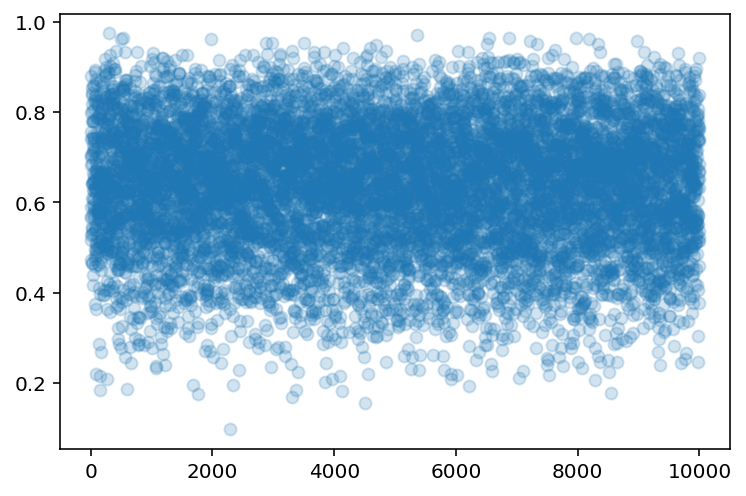

In [9]:
plt.scatter(range(len(sample_rows)), sample_rows, alpha=0.2);


##### Code 3.5

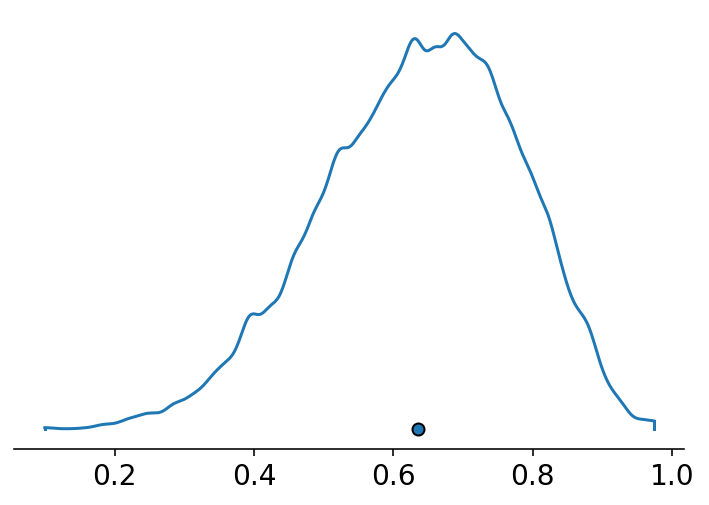

In [10]:
az.plot_density({"": sample_rows}, hdi_prob=1);


## 3.2 Sampling to summarize

### 3.2.1 Intervals of defined boundaries

##### Code 3.6

In [11]:
tf.reduce_sum(posterior[p_grid < 0.5])


<tf.Tensor: shape=(), dtype=float32, numpy=0.17194836>

##### Code 3.7

In [12]:
sum(sample_rows < 0.5) / 10_000


0.173

##### Code 3.8

In [13]:
sum((sample_rows > 0.5) & (sample_rows < 0.75)) / 10_000


0.6079

### 3.2.2 Intervals of defined mass

##### Code 3.9

In [14]:
np.percentile(sample_rows, 80)


0.7587752938270569

##### Code 3.10

In [15]:
np.percentile(sample_rows, [10, 90])


array([0.4474982 , 0.81082159])

##### Code 3.11

In [16]:
p_grid = tf.linspace(start=0.0001, stop=0.99999, num=1000)
prior = tf.repeat(1.0, 1000)
likelihood = tf.exp(tfd.Binomial(total_count=3, probs=p_grid).log_prob(3))
joint_prob = likelihood * prior
posterior = joint_prob / tf.reduce_sum(joint_prob)

samples = tfd.Categorical(probs=posterior).sample(10_000)
sample_rows = p_grid.numpy()[samples]


##### Code 3.12

In [17]:
np.percentile(sample_rows, q=(25, 75))


array([0.70973164, 0.93293029])

##### Code 3.13

In [18]:
az.hdi(sample_rows, hdi_prob=0.5)


array([0.8418492, 0.9989891], dtype=float32)

### 3.2.3 Point Estimates

##### Code 3.14

In [19]:
p_grid[posterior == max(posterior)]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.99999], dtype=float32)>

##### Code 3.15

In [20]:
stats.mode(sample_rows)[0]


array([0.9889802], dtype=float32)

##### Code 3.16

In [21]:
np.mean(sample_rows), np.median(sample_rows)


(0.80231386, 0.8428501)

##### Code 3.17

In [22]:
sum(posterior * abs(0.5 - p_grid))


<tf.Tensor: shape=(), dtype=float32, numpy=0.31286764>

##### Code 3.18

In [23]:
loss = list(map(lambda d: tf.reduce_sum(posterior * np.abs(d - p_grid)), p_grid))


##### Code 3.19

In [24]:
p_grid[tf.math.argmin(loss)]


<tf.Tensor: shape=(), dtype=float32, numpy=0.8408483>

## 3.3 Sampling to simulate prediction

### 3.3.1 Dummy data

##### Code 3.20

In [25]:
tf.exp(tfd.Binomial(total_count=2, probs=0.7).log_prob(np.arange(3)))


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09      , 0.42000002, 0.48999998], dtype=float32)>

##### Code 3.21

In [26]:
tfd.Binomial(total_count=2, probs=0.7).sample()


<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

##### Code 3.22

In [27]:
tfd.Binomial(total_count=2, probs=0.7).sample((10,))


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 2., 2., 1., 2., 1., 0., 2., 1.], dtype=float32)>

##### Code 3.23

In [28]:
dummy_w = tfd.Binomial(total_count=2, probs=0.7).sample((100000,))

np.unique(dummy_w.numpy(), return_counts=True)[1] / 1e5


array([0.09059, 0.41943, 0.48998])

##### Code 3.24

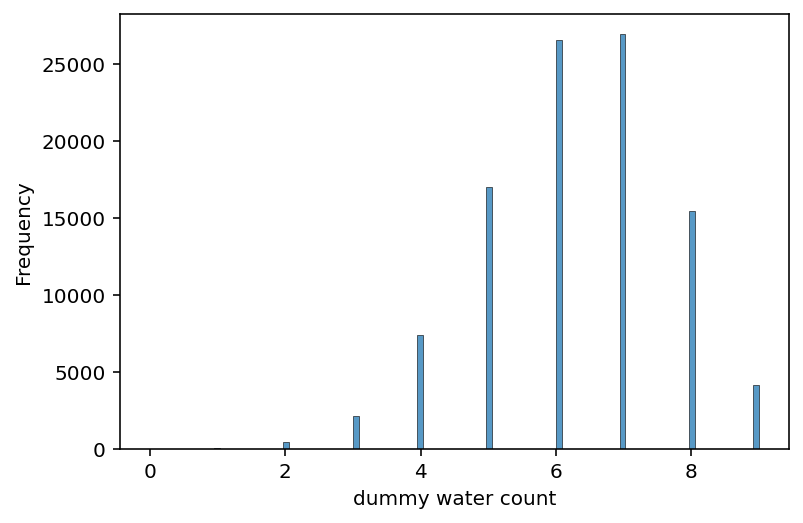

In [29]:
dummy_w = tfd.Binomial(total_count=9, probs=0.7).sample((100000,))
ax = sns.histplot(dummy_w.numpy())
ax.set_ylabel("Frequency")
ax.set_xlabel("dummy water count");


### 3.3.2 Model Checking

##### Code 3.25

In [30]:
w = tfd.Binomial(total_count=9, probs=0.6).sample((int(1e4),))


##### Code 3.26

In [31]:
w = tfd.Binomial(total_count=9, probs=sample_rows).sample()
